Projet d'optimisation groupe 1 : Maxence Lamarque / Eliott Barbier

## 1 Etude du problème d'optimisation

### Question 1

Normalement la facture d'électrcité sur $[t_0, t_f]$ devrait s'écrire:
$$
\int_{t_0}^{t_f}c(t)P(t)dt
$$
puisque $P(t)dt$ représente l'énergie consommée pendant dt
C'est-à-dire une facture de, en approximant l'intégrale par la méthode des rectangles:
$$
\boxed{\sum_{i=0}^{N}\Delta t c_i P_i}
$$

### Question 2
On part de l'équation discrète pour essayer d'obtenir une équation continue, en approximant $T_{i+1} \approx T(t_0 + \Delta t)$, et $\frac{dT}{dt} \approx \frac{T_{i+1} - T_i}{dt}$
Et en utilisant la linéarisation de $e^{-(k+h)\Delta t} - 1 \approx -(k+h)\Delta t$
On a alors :
$$
\boxed{\frac{dT}{dt}= h(T^e - T) -kT +bP}
$$

On reconnait un terme de transfert conducto-convectif $ h(T^e - T)$, un terme de puissance interne dissipée $bP$ et enfin un terme de conduction dû au transfert de chaleur de l'extérieur vers l'intérieur $-kT$.
Physiquement cette modélisation semble raisonnable, puisqu'elle inclue tous les transferts de chaleur de notre situation.



### Question 3

On cherche à minimiser la facture, sous contrainte sur la température et la puissance dissipée, formellement en notant:

$$x = (T_0, T_1, ..., T_N, P_0, ..., P_N) \in \mathbb{R}^{2N+2}, \; f(x) = \sum_{i=0}^{N}\Delta t c_i P_i $$


$c_{eq}(x)=(T_0-T_{in},\; T_1-e^{-(k+h)\Delta t}T_0 - \frac{(1-e^{-(k+h)\Delta t})}{k+h}(bP_0+hT_0^e),\;..., T_N-e^{-(k+h)\Delta t}T_{N-1} - \frac{(1-e^{-(k+h)\Delta t})}{k+h}(bP_{N-1}+hT_{N-1}^e), P_N) \in \mathbb{R}^{N+2}$

et

$$c_{in}(x) = (T_m-T_0,\;..., T_m-T_N,\; T_0-T_M,\;,..., T_N-T_M,\; -P_0, ..., \;-P_N,\; P_0-P_M,...,\; P_N-P_M) \in \mathbb{R}^{4N+4}$$

Dans la définition de $c_ {in}$, on a fait l'hypothèse que $\mathcal{I}_{occ}= (0, ..., N)$, dans la suite les $2N+2$ premières composantes de $c_{in}$ seront ajustées selon $\mathcal{I}_{occ}$

Le problème d'optimisation à résoudre se réécrit :

$$min_{x \in \mathbb{R}^{2N+2}} f(x)$$
$$c_{eq}(x)=0$$
$$c_{in}(x) \leq 0$$



### Question 4
f ainsi définit est linéaire, et les contraintes affines, donc il s'agit d'un problème convexe. Plus spécifiquement, il s'agit d'un problème LP.

## 2 Etude et résolution numérique du problème individuel

### Question 5

Etant donné la nature de notre problème d'optimisation d'une fonction différetentiable convexe sous contraintes aussi différentiables convexes, il est possible d'utiliser l'algorithme d'Uzawa, d'Arrow-Hurwitz pour rechercher un point selle du Lagrangien. Ce point selle étant alors solution du problème d'optimisation.

Mais étant donné la nature LP du problème, il est préférable d'utiliser l'algorithme du simplexe.

In [127]:
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

In [128]:
#Données question 5
c_cr = 1
c_pl = 3/2
Tm = 18.#(°C)
TM = 30.#(°C)
Tin = Tm
h = 0.05#h-1
k = 0.01#h-1
b = 1/500#°C/Wh
PM = 5000.#W
t0 = 23.
dt = 0.5
N = 48#Pour une durée de 24h
gamma = np.exp(-(k+h)*dt)
beta = (1-gamma)/(k+h)
Iocc = np.concatenate((np.arange(16, 21), np.arange(38, 49)))
tab_bool = np.array([1 if i in Iocc else 0 for i in range(2*N + 1)])


t = np.concatenate((np.array([23., 23.5]), dt * np.arange(N - 1)))#array des temps modulo 24
Te = 4 + 8 * np.exp(-(t -12)**2/40)# array des températures extérieures
cost = np.where(((t >= 0.) & (t <= 6.) | (t>=12.) & (t<=14.)), c_cr, c_pl)#array des coûts horaires


Où on a  introduit $\gamma := e^{-(k+h)\Delta t}\;$ et $\;\beta := (\frac{1-e^{-(k+h)\Delta t}}{k+h})$

On réécrit le problème d'optimisation sous la forme :
$$f(x) = c^Tx, \; c_{in}(x) = A_{in}x - b_{in},\; c_{eq}(x) = A_{eq}x - b_{eq}$$

Avec 
$$A_{eq} \in \mathbb{R}^{(N+2) \times (2N+2)}, \;b_{eq}\in \mathbb{R}^{N+2},\;A_{in} \in \mathbb{R}^{(4N+4) \times (2N+2)}, \;b_{in}\in \mathbb{R}^{4N+4}, \; c \in \mathbb{R}^{2N+2}$$

### Question 6

In [129]:
#Ecriture des matrices décrivant le problème
c = np.zeros( (2*N+2,) ) 
Aeq = np.zeros((N+2, (2*N+2)))
beq = np.zeros( (N+2,) )
Ain = np.zeros((4*N+4, (2*N+2)))
b_in = np.zeros( (4*N+4,) )

In [130]:
def compute_matrix(c_cr=c_cr, c_pl=c_pl):
    '''
    Calcul les matrices utilisées dans le problème d'optimisation traité
    Paramètres: c_cr coût heure creuse, c_pl coût heure pleine
    Ne renvoie rien, modifie juste les matrices
    '''

    cost = np.where(((t >= 0.) & (t <= 6.) | (t>=12.) & (t<=14.)), c_cr, c_pl)
    #Vecteur ligne c:
    c[N+1:] = dt * cost

    #Vecteur ligne beq:
    beq[0] = Tin # 1 condition
    beq[1:N+1] = h*beta*Te[:len(Te)-1] #N condition
    #Le b_eq en N+1 correspond à la contrainte P_N = 0

    #Matrice Aeq:

    #Première ligne
    Aeq[0, 0] = 1.

    #lignes suivantes j'ai pas d'autres idées que de faire ça, un peu dégeu on peut sans doute faire mieux à partir d'un produit matriciel avec une 
    #matrice bien choisie

    for i in range(1, N+1):
        Aeq[i, i-1] = -gamma
        Aeq[i, i] = 1
        Aeq[i, N + i] = -beta*b

    #Vecteur ligne bin:

    #Marche pas... bin = np.where(((bin in Iocc) & (bin <= N) | (bin in Iocc) & (bin >= N+1)), -Tm, TM)
    for i in Iocc:
            b_in[i] = -Tm
            b_in[i+N+1] = TM
    b_in[3*N+3:] = PM


    #Matrice Ain:
    for i in Iocc:
            Ain[i, i] = -1.
            Ain[i+N+1, i] = 1
            
    Ain[2*N+2:3*N+3, N+1:] = -np.eye(N+1)
    Ain[3*N+3:, N+1:] = np.eye(N+1)

In [131]:
#Exécution de l'algorithme du simplexe:
compute_matrix()
res = scipy.optimize.linprog(c, A_ub=Ain, b_ub=b_in, A_eq=Aeq, b_eq=beq, bounds=(None, None), method='revised simplex', callback=None, options=None, x0=None)

In [132]:
#Vérification du succès de l'algortihme
print(f"{res.success=}")
print("Les températures : ", res.x[0:N+1])
print("Les puissances :", res.x[N+1:])
print(f"{res.nit=}") #Nombre d'itérations"

res.success=True
Les températures :  [18.         17.57610183 17.16238621 16.75905952 16.36949115 15.9937818
 15.63212621 15.28481514 14.95223287 14.63484921 14.33320482 14.04788911
 13.77951036 13.52865818 15.0596063  19.7188933  19.32711722 18.95989191
 18.61681733 18.29719513 18.         17.72386596 17.46708995 17.22765423
 17.00326778 16.79142526 16.58948071 16.39473212 16.20451163 16.01627592
 18.27239861 22.93490683 22.52412128 22.11427925 21.70427224 21.29340195
 20.88136173 20.46820155 20.05428007 19.64020774 19.22678534 18.81494186
 18.4056754  18.         18.         18.         18.         18.
 18.        ]
Les puissances : [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.         1790.33541736 5000.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.        

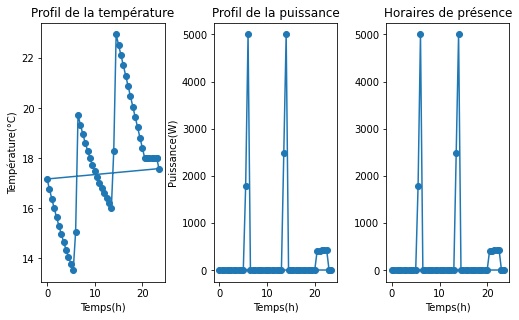

In [133]:
#Résultats
T = res.x[:N+1]
P = res.x[N+1:]

#Affichage du résultat:

#Température
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
axes[0].plot(t, T, marker="o")
axes[0].set_xlabel("Temps(h)")
axes[0].set_ylabel("Température(°C)")
axes[0].set_title("Profil de la température")

#Puissance
axes[1].plot(t, P, marker="o")
axes[1].set_xlabel("Temps(h)")
axes[1].set_ylabel("Puissance(W)")
axes[1].set_title("Profil de la puissance")

#Iocc
axes[2].plot(t, P, marker="o")
axes[2].set_xlabel("Temps(h)")
axes[2].set_title("Horaires de présence")

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=1.4, 
                    top=1.4, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [134]:
#Résultat de la facture après optimisation
print(f"Total de la facture :{round(res.fun, 2)} €")

Total de la facture :8703.96 €


Commentaires :
La facture est extrêment salée pour seulement 24 heures, à moins d'être propriétaire de Tesla l'hiver risque d'être rude, ou alors notre méthode de résolution est inadaptée.

### Avec $c_{pl} = \frac{7}{4}$

### Question 7

In [135]:
#Exécution de l'algortihme du simplexe, c_pl = 7/4
c = np.zeros( (2*N+2,) ) 
Aeq = np.zeros((N+2, (2*N+2)))
beq = np.zeros( (N+2,) )
Ain = np.zeros((4*N+4, (2*N+2)))
b_in = np.zeros( (4*N+4,) )
compute_matrix(c_pl=7/4)
res = scipy.optimize.linprog(c, A_ub=Ain, b_ub=b_in, A_eq=Aeq, b_eq=beq, bounds=(None, None), method='revised simplex', callback=None, options=None, x0=None)

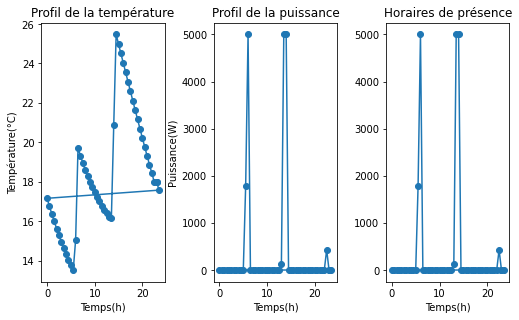

In [136]:
#Avec des tarifs d'heures pleines différents:

#Avec c_pl = 7/4

c = np.zeros( (2*N+2,) ) 
Aeq = np.zeros((N+2, (2*N+2)))
beq = np.zeros( (N+2,) )
Ain = np.zeros((4*N+4, (2*N+2)))
b_in = np.zeros( (4*N+4,) )
compute_matrix(c_pl=7/4)

#Résultats
T = res.x[:N+1]
P = res.x[N+1:]

#Affichage du résultat:

#Température
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
axes[0].plot(t, T, marker="o")
axes[0].set_xlabel("Temps(h)")
axes[0].set_ylabel("Température(°C)")
axes[0].set_title("Profil de la température")

#Puissance
axes[1].plot(t, P, marker="o")
axes[1].set_xlabel("Temps(h)")
axes[1].set_ylabel("Puissance(W)")
axes[1].set_title("Profil de la puissance")

#Iocc
axes[2].plot(t, P, marker="o")
axes[2].set_xlabel("Temps(h)")
axes[2].set_title("Horaires de présence")

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=1.4, 
                    top=1.4, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [137]:
#Résultat de la facture après optimisation avec c_pl=7/4
print(f"Total de la facture :{round(res.fun, 2)} €")

Total de la facture :8837.31 €


### Avec $c_{pl} = 2$

In [138]:
#Exécution de l'algortihme du simplexe, c_pl = 2
c = np.zeros( (2*N+2,) ) 
Aeq = np.zeros((N+2, (2*N+2)))
beq = np.zeros( (N+2,) )
Ain = np.zeros((4*N+4, (2*N+2)))
b_in = np.zeros( (4*N+4,) )
compute_matrix(c_pl=2)
res = scipy.optimize.linprog(c, A_ub=Ain, b_ub=b_in, A_eq=Aeq, b_eq=beq, bounds=(None, None), method='revised simplex', callback=None, options=None, x0=None)

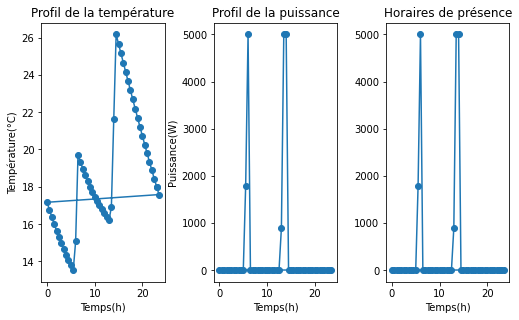

In [139]:
#Avec des tarifs d'heures pleines différents:

#Avec c_pl = 7/4

c = np.zeros( (2*N+2,) ) 
Aeq = np.zeros((N+2, (2*N+2)))
beq = np.zeros( (N+2,) )
Ain = np.zeros((4*N+4, (2*N+2)))
b_in = np.zeros( (4*N+4,) )
compute_matrix(c_pl=7/4)

#Résultats
T = res.x[:N+1]
P = res.x[N+1:]

#Affichage du résultat:

#Température
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
axes[0].plot(t, T, marker="o")
axes[0].set_xlabel("Temps(h)")
axes[0].set_ylabel("Température(°C)")
axes[0].set_title("Profil de la température")

#Puissance
axes[1].plot(t, P, marker="o")
axes[1].set_xlabel("Temps(h)")
axes[1].set_ylabel("Puissance(W)")
axes[1].set_title("Profil de la puissance")

#Iocc
axes[2].plot(t, P, marker="o")
axes[2].set_xlabel("Temps(h)")
axes[2].set_title("Horaires de présence")

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=1.4, 
                    top=1.4, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [156]:
#Résultat de la facture après optimisation avec c_pl=2
print(f"Total de la facture :{round(res.fun, 2)} €")

Total de la facture :19611.53 €


Commentaires:
Sur les heures creuses, la température augmente plus lorsque $c_{pl}$ augmente, pour compenser la hausse des prix.

## Partie 3

### Question 8.a)

On cherche à minimiser la facture globale, sous contrainte sur la température et la puissance dissipée; formellement en notant:
$$x = (T^{1}_0, T^{1}_1, ..., T^{1}_N, P^{1}_0, ..., P^{1}_N, ..., T^{n_l}_0, T^{n_l}_1, ..., T^{n_l}_N, P^{n_l}_0, ..., P^{n_l}_N) \in \mathbb{R}^{(2N+2){n_l}}$$


$$f(x) = \sum_{j=1}^{n_l}\sum_{i=0}^{N}\Delta t c_i P^{j}_i $$



$$c_{eq}(x)=(T^{1}_0-T_{in},\; T^{1}_1-e^{-(k+h+\sum_{k \ne 1}h_{1k})\Delta t}T^{1}_0 - \frac{(1-e^{-(k+h+\sum_{k \ne 1}h_{1k})\Delta t})}{k+h+\sum_{k \ne 1}h_{1k}}(bP^{1}_0+hT_0^e+\sum_{k \ne 1}h_{1k}T^{k}_{0}),\;...\newline \newline,\; T^{1}_N-e^{-(k+h+\sum_{k \ne 1}h_{1k})\Delta t}T^{1}_{N-1} - \frac{(1-e^{-(k+h+\sum_{k \ne 1}h_{1k})\Delta t})}{k+h+\sum_{k \ne 1}h_{1k}}(bP^{1}_{N-1}+hT_{N-1}^e+\sum_{k \ne 1}h_{1k}T^{k}_{N-1}),\; P^{1}_N,... \newline \newline,\; T^{n_l}_0-T_{in},\; T^{n_l}_1-e^{-(k+h+\sum_{k \ne n_l}h_{n_{l}k})\Delta t}T^{n_l}_0 - \frac{(1-e^{-(k+h+\sum_{k \ne n_l}h_{n_{l}k})\Delta t})}{k+h+\sum_{k \ne n_l}h_{n_{l}k}}(bP^{n_l}_0+hT_0^e+\sum_{k \ne n_l}h_{n_{l}k}T^{k}_{0}),\;...\newline \newline,\; T^{n_l}_N-e^{-(k+h+\sum_{k \ne n_l}h_{n_{l}k})\Delta t}T^{n_l}_{N-1} - \frac{(1-e^{-(k+h+\sum_{k \ne n_l}h_{n_{l}k})\Delta t})}{k+h+\sum_{k \ne n_l}h_{n_{l}k}}(bP^{n_l}_{N-1}+hT_{N-1}^e+\sum_{k \ne n_l}h_{n_{l}k}T^{k}_{N-1}),\; P^{n_l}_N) \in \mathbb{R}^{(N+2)n_l}$$

#

$$c_{in}(x) = (T^{1}_m-T^{1}_0,\;..., T^{1}_m-T^{1}_N,\; T^{1}_0-T^{1}_M,\;..., T^{1}_N-T^{1}_M,\; -P^{1}_0, ..., \;-P^{1}_N,\; P^{1}_0-P^{1}_M,...,\; P^{1}_N-P^{1}_M,... \newline \newline, T^{n_l}_m-T^{n_l}_0,\;..., T^{n_l}_m-T^{n_l}_N,\; T^{1}_0-T^{1}_M,\;,..., T^{n_l}_N-T^{n_l}_M,\; -P^{n_l}_0, ..., \;-P^{n_l}_N,\; P^{n_l}_0-P^{n_l}_M,...,\; P^{n_l}_N-P^{n_l}_M) \in \mathbb{R}^{(4N+4)n_l}$$


Le problème d'optimisation à résoudre se réécrit :

$$min_{x \in \mathbb{R}^{(2N+2)n_l}} f(x)$$
$$c_{eq}(x)=0$$
$$c_{in}(x) \leq 0$$

On réécrit le problème d'optimisation sous la forme matricielle suivante:
$$f(x) = c^Tx, \; c_{in}(x) = A_{in}x - b_{in},\; c_{eq}(x) = A_{eq}x - b_{eq}$$

Avec 
$$A_{eq} \in \mathbb{R}^{(N+2)n_l \times (2N+2)n_l}, \;b_{eq}\in \mathbb{R}^{(N+2)n_l},\;A_{in} \in \mathbb{R}^{(4N+4)n_l \times (2N+2)n_l}, \;b_{in}\in \mathbb{R}^{(4N+4)n_l}, \; c \in \mathbb{R}^{(2N+2)n_l}$$

### Question 8.b)

# A faire

### Question 8.c)

In [141]:
#On remet à jour l'array cost avec les bonnes valeurs
c_cr = 1
c_pl = 3/2
cost = np.where(((t >= 0.) & (t <= 6.) | (t>=12.) & (t<=14.)), c_cr, c_pl)

In [142]:
#On met x sous la forme (T0^1,...,TN^1,P0^1,..P0^N,T0^2,...TN^2,P0^2,...PN^2)
gamma = np.exp(-(k+h+h)*dt) #Car h12=h21=h et on a que 2 maisons
beta = (1 - gamma)/(k+h+h)
Tm1 = 18
Tm2 = 20
Aeq = np.zeros( (2*(N+2), 2*(2*N+2) ) )
c = np.zeros( (2*(2*N+2),) )
beq = np.zeros( (2*(N+2),) )
Ain = np.zeros( (2*(4*N+4), 2*(2*N+2)) )
b_in = np.zeros( (2*(4*N+4),) )

In [143]:
c[N+1:2*N+2] = dt * cost
c[3*N+3:] = dt * cost

beq_1 = np.zeros( (N+2,) )
beq_1[0] = Tin # 1 condition
beq_1[1:N+1] = h*beta*Te[:len(Te)-1] #N conditions
beq[:N+2] = beq_1
beq[N+2:] = beq_1

#On décompose la matrice Aeq en 4 blocs, et on peut réutiliser les constructions précédentents pour Aeq_1 et Aeq_2
Aeq_1 = np.zeros( (N+2, 2*N+2) )
Aeq_2 = np.zeros( (N+2, 2*N+2) )
Aeq_3 = np.zeros( (N+2, 2*N+2) )
Aeq_4 = np.zeros( (N+2, 2*N+2) )

Aeq_1[0, 0] = 1.
for i in range(1, N+1):
    Aeq_1[i, i-1] = -gamma
    Aeq_1[i, i] = 1
    Aeq_1[i, N + i] = -beta*b
    Aeq_2[i,i-1] = -beta*h


Aeq_3[0, 0] = 1.
for i in range(1, N+1):
    Aeq_3[i, i-1] = -gamma
    Aeq_3[i, i] = 1
    Aeq_3[i, N + i] = -beta*b
    Aeq_4[i,i-1] = -beta*h

Aeq[0:N+2, 0:2*N+2] = Aeq_1
Aeq[0:N+2, 2*N+2:] = Aeq_2
Aeq[N+2:, 0:2*N+2] = Aeq_4
Aeq[N+2:, 2*N+2:] = Aeq_3
#On recrée Ain, par bloc aussi, c'est plus facile car elle est diagonale par blocs avec comme bloque la Ain précédente : (cas où Iocc est le même pour les 2 maisons, sinon
#les 2 matrices dans la diagonale ne sont pas les mêmes.)

Ain_1 = np.zeros( (4*N+4, 2*N+2) )
for i in Iocc:
    Ain_1[i, i] = -1.
    Ain_1[i+N+1, i] = 1
Ain_1[2*N+2:3*N+3, N+1:] = -np.eye(N+1)
Ain_1[3*N+3:, N+1:] = np.eye(N+1)

Ain[0:4*N+4,0:2*N+2] = Ain_1
Ain[4*N+4:,2*N+2:] = Ain_1

b_in_1 = np.zeros( (4*N+4,) )
for i in Iocc:
    b_in_1[i] = -Tm1
    b_in_1[i+N+1] = TM
b_in_1[3*N+3:] = PM

b_in_2 = np.zeros( (4*N+4,) )
for i in Iocc:
    b_in_2[i] = -Tm2
    b_in_2[i+N+1] = TM
b_in_2[3*N+3:] = PM

b_in[0:4*N+4]=b_in_1
b_in[4*N+4:] = b_in_2

In [144]:
#Exécution de l'algorithme du simplexe:
res = scipy.optimize.linprog(c, A_ub=Ain, b_ub=b_in, A_eq=Aeq, b_eq=beq, bounds=(None, None), method='revised simplex', callback=None, options=None, x0=None)

In [145]:
#On vérifie que l'algorithme s'exécute correctement
print(f"Succes:{res.success}")

Succes:True


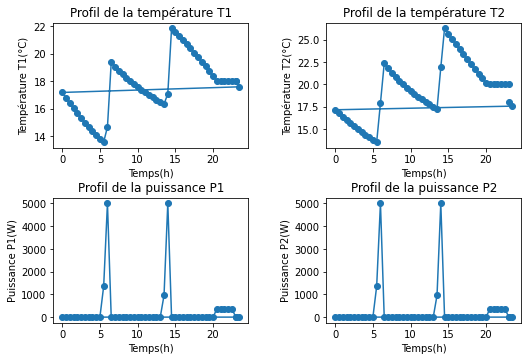

In [153]:
#Affichage des résultats
fig, axes = fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 3))
T1, T2 = res.x[0:N+1], res.x[2*N+2:3*N+3]
P1, P2 = res.x[N+1:2*N+2], res.x[3*N+3:]

#Températures

#T1
axes[0, 0].plot(t, T1, marker="o")
axes[0, 0].set_xlabel("Temps(h)")
axes[0, 0].set_ylabel("Température T1(°C)")
axes[0, 0].set_title("Profil de la température T1")

#T2
axes[0, 1].plot(t, T2, marker="o")
axes[0, 1].set_xlabel("Temps(h)")
axes[0, 1].set_ylabel("Température T2(°C)")
axes[0, 1].set_title("Profil de la température T2")

#Puissances

#P1
axes[1, 0].plot(t, P1, marker="o")
axes[1, 0].set_xlabel("Temps(h)")
axes[1, 0].set_ylabel("Puissance P1(W)")
axes[1, 0].set_title("Profil de la puissance P1")

#P2
axes[1, 1].plot(t, P1, marker="o")
axes[1, 1].set_xlabel("Temps(h)")
axes[1, 1].set_ylabel("Puissance P2(W)")
axes[1, 1].set_title("Profil de la puissance P2")

plt.subplots_adjust(left=0.1,
                    bottom=0.01, 
                    right=1.4, 
                    top=1.4, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [157]:
#Résultat de la facture après optimisation
print(f"Total de la facture :{round(res.fun, 2)} €")

Total de la facture :19611.53 €
